# INF554 Kaggle challenge notebook
Team: Kagglers

Members: Marian Huot, Antoine Gleisberg, Aude Bouillé

## Part 0 : general imports and data reading

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

import seaborn as sns

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from verstack.stratified_continuous_split import scsplit

In [39]:
# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")

## Part 1 : data visualisation and feature plotting

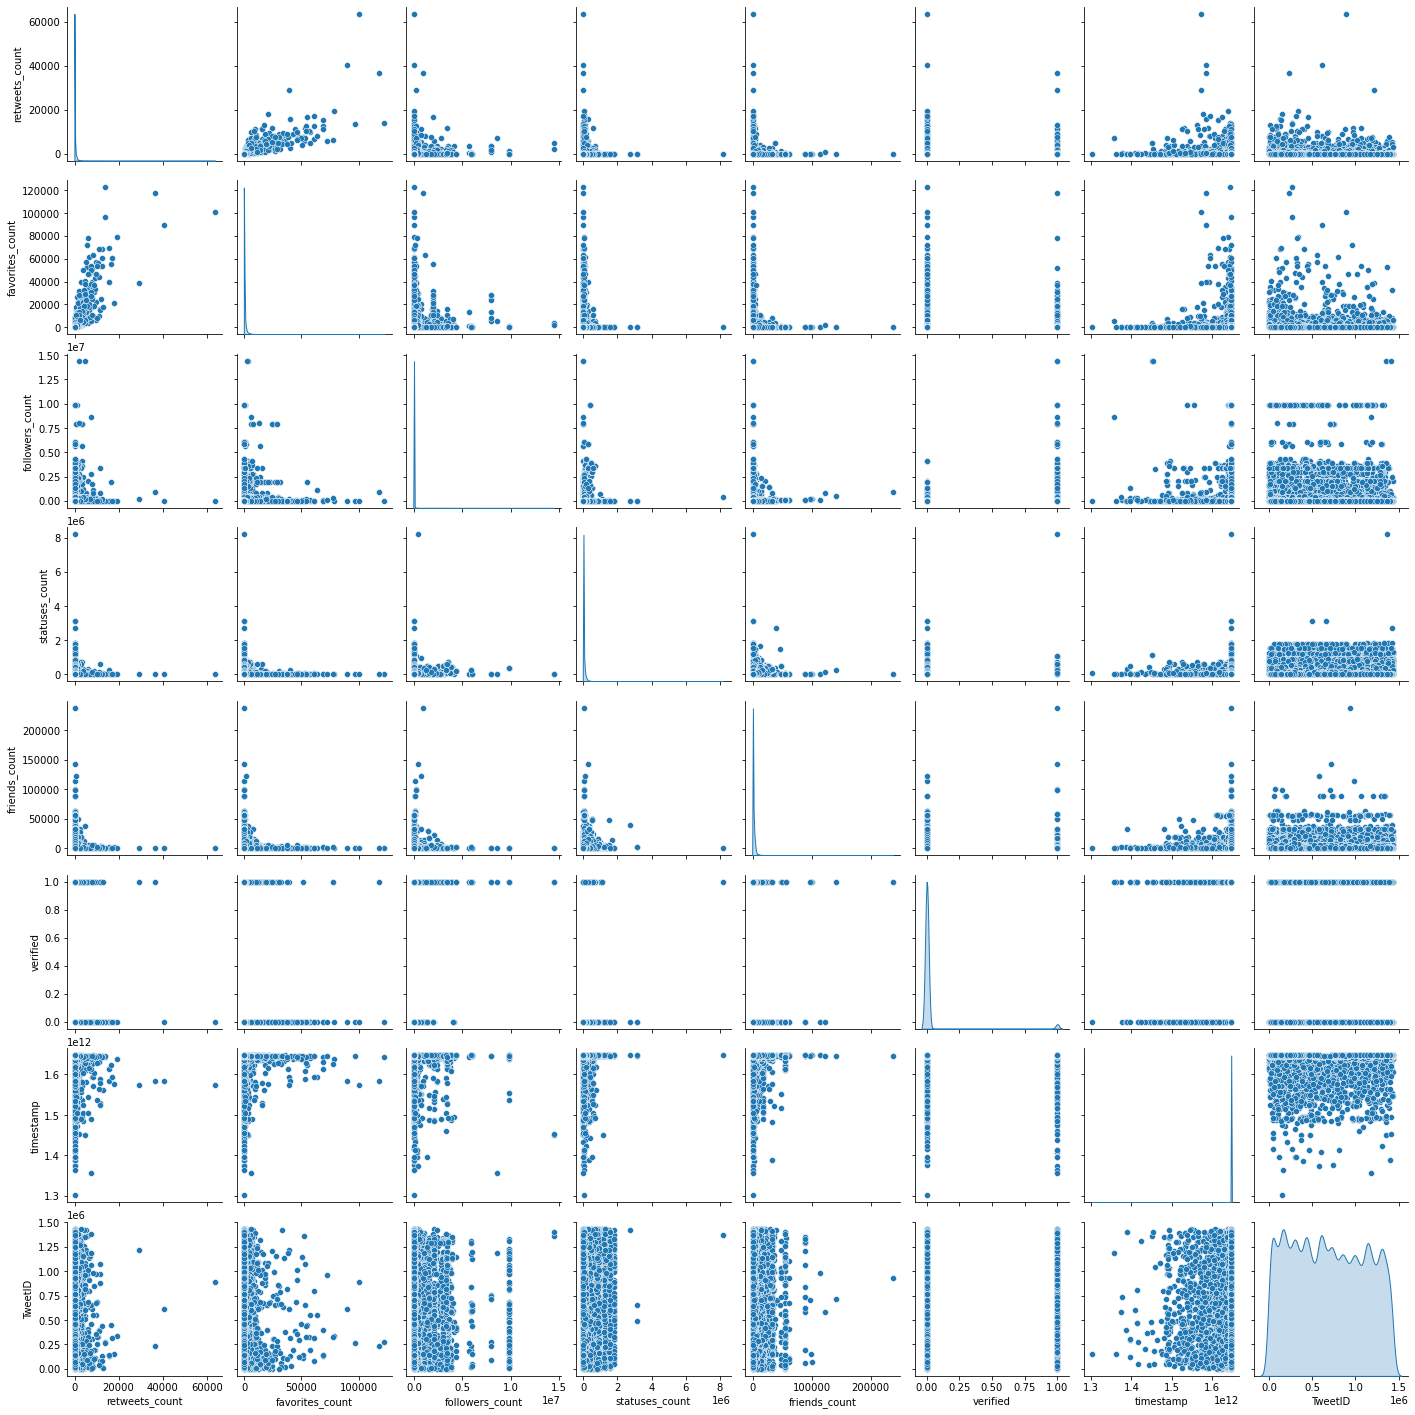

In [40]:
sns.pairplot(train_data, diag_kind='kde')

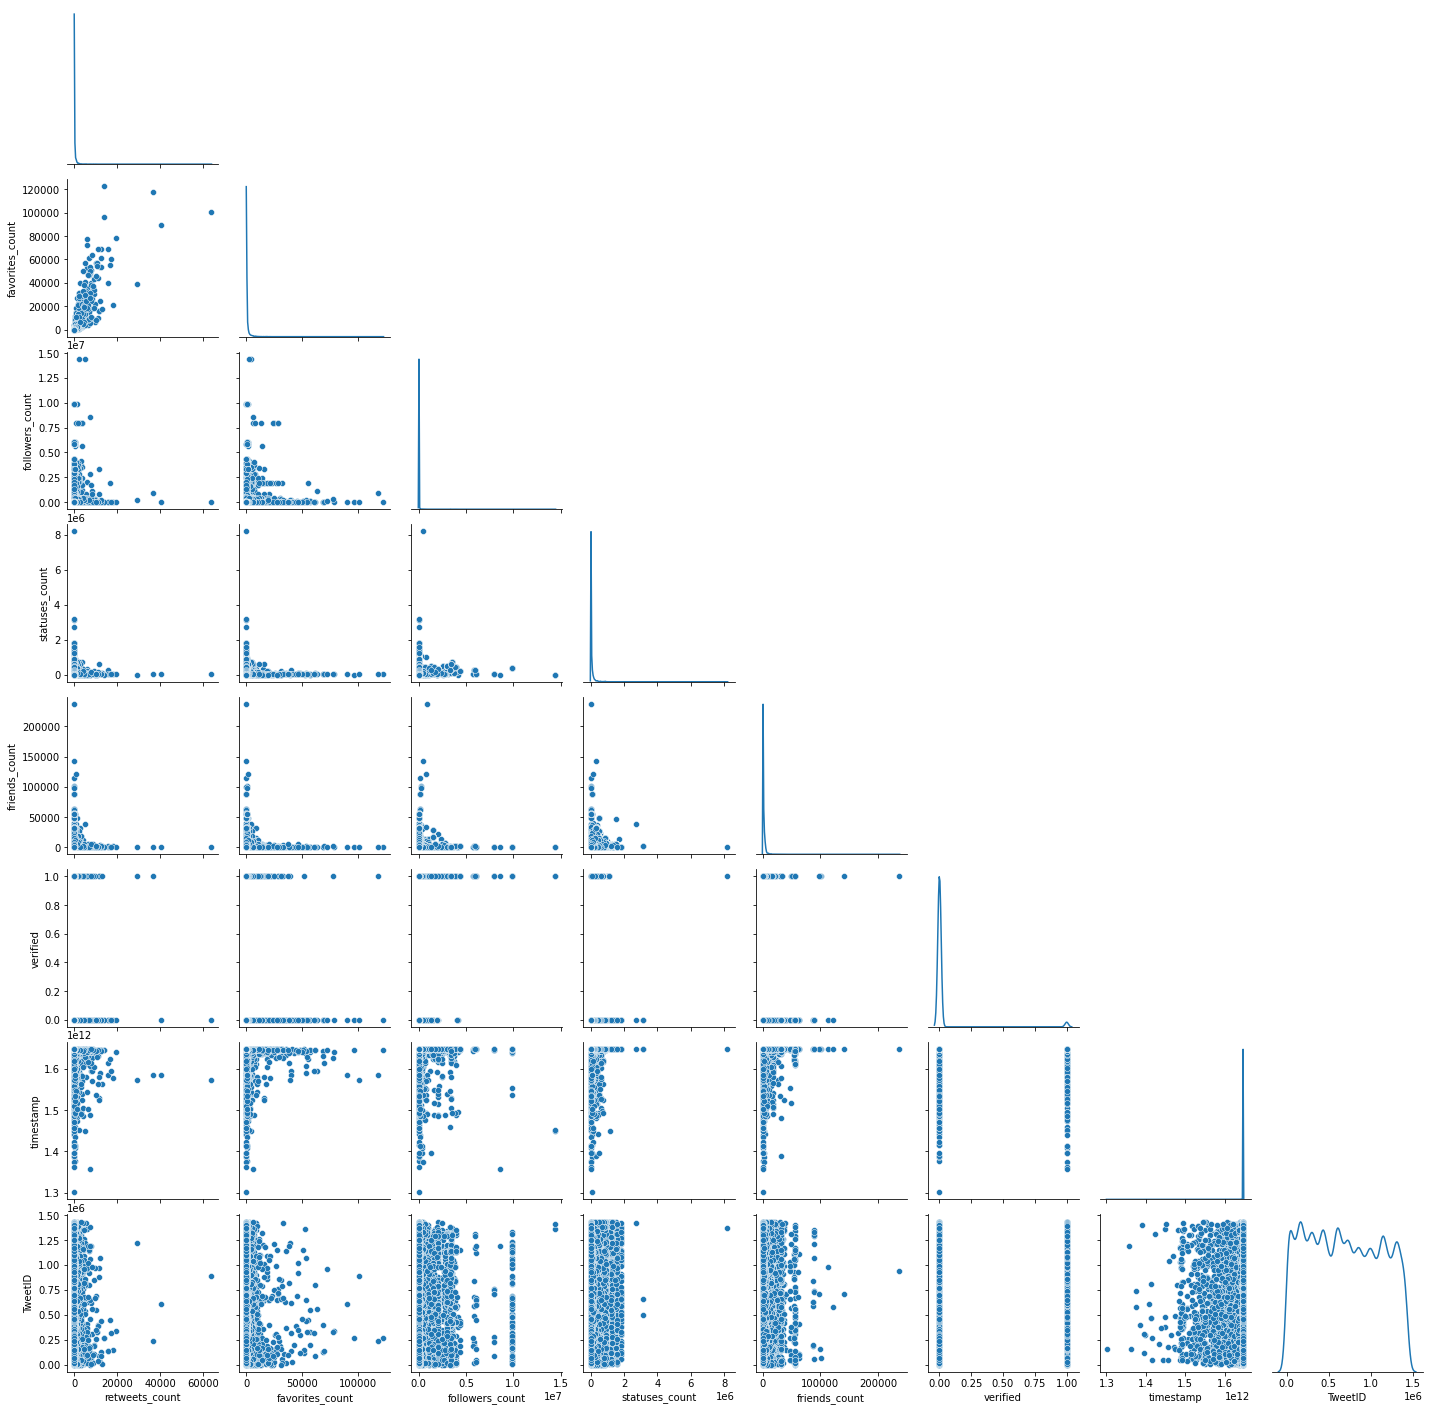

In [41]:
g = sns.PairGrid(train_data, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

In [42]:
def visualize_retweets(n_max, n_min=-1, k=True, b=30):
    y = train_data['retweets_count']
    sns.displot(y[y < n_max][n_min < y], kde=k, bins=b)

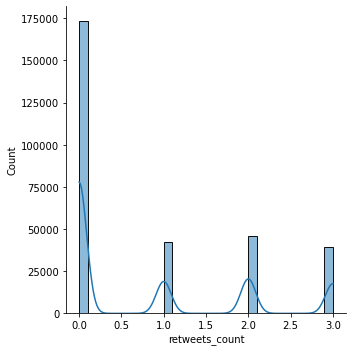

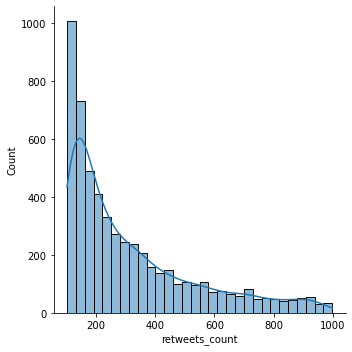

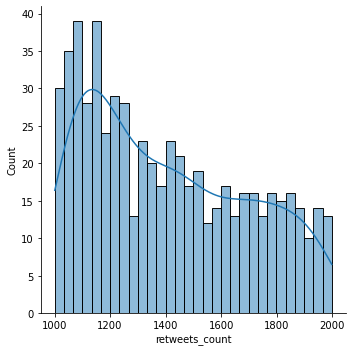

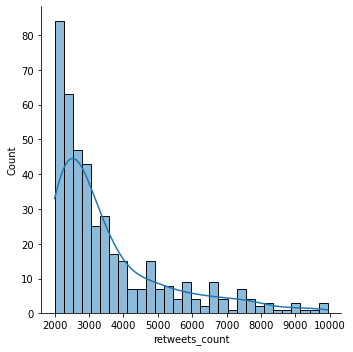

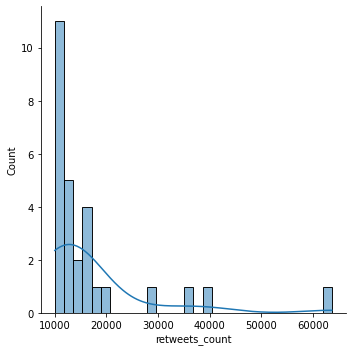

In [43]:
visualize_retweets(4)
visualize_retweets(1000, 100)
visualize_retweets(2000, 1000)
visualize_retweets(10000, 2000)
visualize_retweets(70000, 10000)

## Part 2 : Outlier removal and feature selection

### Part 2.1 : Removal of outliers

This wasn't used in the end because it made results worse than without it.

In [44]:
# remove outliers with quartile
def remove_outliers(df: pd.DataFrame, col: str) -> pd.DataFrame:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 5 * iqr) & (df[col] <= q3 + 5 * iqr)]
    return df

# remove outliers with given percentage p
def remove_outliers_percentage(df, col, p):
    q = df[col].quantile(1 - p / 100)
    df = df[df[col] < q]
    return df

# remove outliers with retweets_count above n
def remove_outliers_above(df, col, n):
    df = df[df[col] < n]
    return df

def percentage_outliers_above(df, col, n):
    z = df[col].copy()
    z[z < n] = 0
    print(f"n = {n} ; Percentage of outliers : {round(len(z[z > 0]) / len(z) * 100, 4)}%")

In [45]:
percentage_outliers_above(train_data, 'retweets_count', 7000)

n = 7000 ; Percentage of outliers : 0.0155%


### Part 2.2 : Train - Test split

In [46]:
# split data using stratified continuous split
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.8, test_size=0.2)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)


# split data using sklearn
# X = train_data.drop('retweets_count',axis=1)
# y = train_data['retweets_count']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Part 2.3 : Adding new features

See file utils.py for the functions used to create the new features.

### Part 2.4 : Feature selection

In [47]:
columns = ['TweetID', 'mention', 'urls', 'timestamp', 'text', 'total_text', 'hashtags', 'followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'verified', 'url_count', 'followers_friends',
       'hour', 'day','week_in_month', 'polarity', 'subjectivity', 'hashtags_count', 'topic_1','topic_2', 'topic_3','topic_4', 'topic_5','cluster']

useless_cols = ["TweetID", "mention", "urls", "timestamp", "text", "hashtags", "total_text"]

In [48]:
from utils import clean_data

In [49]:
new_train_data = clean_data(X_train, columns, useless_cols)
new_test_data = clean_data(X_test, columns, useless_cols)

This section was used for testing purposes : trying to remove different features for the best possible results

In [50]:
unimportant_cols = []

In [51]:
new_train_data = new_train_data.drop(unimportant_cols, axis=1)
new_test_data = new_test_data.drop(unimportant_cols, axis=1)

In [52]:
new_train_data.head()

,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,hour,day,week_in_month,polarity,subjectivity,hashtags_count,topic_1,topic_2,topic_3,topic_4,topic_5,cluster
244080,4845,3298,0,130671,0,1,1.468627,5,2,2,-0.20,0.100000,1,0.020536,-0.008980,-0.000125,-0.010376,0.022586,50
205875,1255,1215,19,66371,0,1,1.032072,7,5,1,0.00,0.100000,0,0.140417,-0.048464,-0.074315,0.043592,-0.007374,89
204692,16721,1656,9,45177,0,1,10.091129,10,4,2,0.10,0.000000,0,0.074707,-0.047102,-0.026118,-0.017518,0.014032,14
316037,3552,4977,2,85489,0,1,0.713540,16,3,2,-0.15,0.566667,1,0.070501,-0.033930,-0.037295,0.006991,-0.013249,11
331429,4013,1067,78,48481,0,1,3.757491,16,3,2,0.24,0.225000,0,0.175729,0.067464,-0.109490,-0.018573,-0.041524,14


## Part 3 : Model selection

## Pipeline to get a first overview befopre optimizing

Importing different regressors

In [53]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [54]:
pipelines: List[Tuple[str, bool, Tuple[float, float], Pipeline]] = []
pipelines.append(('ScaledKNN',      False, (0, 0), Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(5))])))
pipelines.append(('ScaledLR',       False, (0, 0), Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())] )))
# pipelines.append(('ScaledGBM',      False, (0, 0), Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('UnscaledGBM',    False, (0, 0), Pipeline([('GBM', GradientBoostingRegressor())])))
# pipelines.append(('ScaledCART',     False, (0, 0), Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeRegressor())])))
pipelines.append(('UnscaledCART',  False, (0, 0), Pipeline([('CART', DecisionTreeRegressor())])))
# pipelines.append(('ScaledRF',       False, (0, 0), Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
pipelines.append(('UnscaledRF',     False, (0, 0), Pipeline([('RF', RandomForestRegressor(n_estimators=10))])))


# pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
# pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
# pipelines.append(('OptimizedRF', Pipeline([('RF', RandomForestRegressor(max_features=0.93, max_leaf_nodes=2310, n_estimators=90, n_jobs=-1))])))
# pipelines.append(('OptimizedXGB', Pipeline([('XGB', XGBRegressor(base_score=0.5, booster='gbtree'))])))


In [55]:
recalculate_models = True

if recalculate_models:
    for i, (name, was_evaluated, (mean, std), model) in enumerate(pipelines):
        if not was_evaluated:
            kfold = KFold(n_splits=10)
            cv_results = cross_val_score(model, new_train_data, y_train, cv=kfold, scoring='neg_mean_absolute_error')
            pipelines[i] = (name, True, (cv_results.mean(), cv_results.std()), model)
        print(f"{name}: {pipelines[i][2][0]} ({pipelines[i][2][1]})")


ScaledKNN: -10.817572247464419 (0.5631834990091459)
ScaledLR: -11.260668993662003 (0.7722165179132684)


Min Max Scaler
- ScaledKNN: -19.18159363427886 (1.5453010098400695)
- ScaledLR: -11.161187928446045 (0.9388509996875113)

Standard Scaler
- ScaledKNN: -10.626873889833448 (0.7770515292830723)
- ScaledLR: -11.161187928446022 (0.9388509996874855)


#we choose the standard scaler for knn and lr which depends on value distribution


In [ ]:
#La cross validation nous donne deja les perfs de chaque modèle
#for name, was_evaluated, (mean, std), model in pipelines:
   # model.fit(new_train_data, y_train)
   # predictions = model.predict(new_test_data)
   # predictions = [round(value) if value >= 0 else 0 for value in predictions]
   # print(f"{name} done.\nMean absolute error: {mean_absolute_error(y_test, predictions)}")

ScaledLR done.
Mean absolute error: 9.881812017967624
ScaledLASSO done.
Mean absolute error: 10.339110659095404
ScaledEN done.
Mean absolute error: 14.335480407944177
ScaledKNN done.
Mean absolute error: 10.022233522614911
ScaledCART done.
Mean absolute error: 9.562943187275758
ScaledGBM done.
Mean absolute error: 6.972751928129503
ScaledRF done.
Mean absolute error: 7.212447382546544
OptimizedRF done.
Mean absolute error: 6.73951182303585
OptimizedXGB done.
Mean absolute error: 6.812173348023844


### Feature selection plot with RFE

### Scaler

In [ ]:
#Use a minmax scaler to scale the data

scaler = StandardScaler()
scaler.fit(new_train_data)
scaled_train_data = scaler.transform(new_train_data)
scaled_test_data = scaler.transform(new_test_data)# used for Lasso and KNN

In [ ]:
lr=LinearRegression()
knn=KNeighborsRegressor(5)
rf=RandomForestRegressor(n_estimators=10)

#Plot mae for each model with rfe
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def plot_mae(model, X, y):
    mae = []
    for i in range(1, len(new_train_data.columns),2):
        rfe = RFE(model, i)
        X_rfe = rfe.fit_transform(X, y)
        mae.append(np.mean(cross_val_score(model, X_rfe, y, scoring='neg_mean_absolute_error')))
    plt.plot(range(1, len(new_train_data.columns)), mae)#use new_train_data.columns because X has been scaled and therefore has no more column names
    plt.xlabel('Number of features')
    plt.ylabel('MAE')
    plt.show()

plot_mae(lr, scaled_train_data, y_train)
plot_mae(knn, scaled_train_data, y_train)
plot_mae(rf, scaled_train_data, y_train)

#Next step^after plot: identify ideal nb of features and get the name of these features
#Then use these features in the model

#ex with top 10 features
#rfe = RFE(lr, 10)
#X_rfe = rfe.fit_transform(new_train_data, y_train)
#mask = rfe.support_


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### Hyper paramter tuning to avoid overfitting

Use identified features for each of these three models

## Lasso

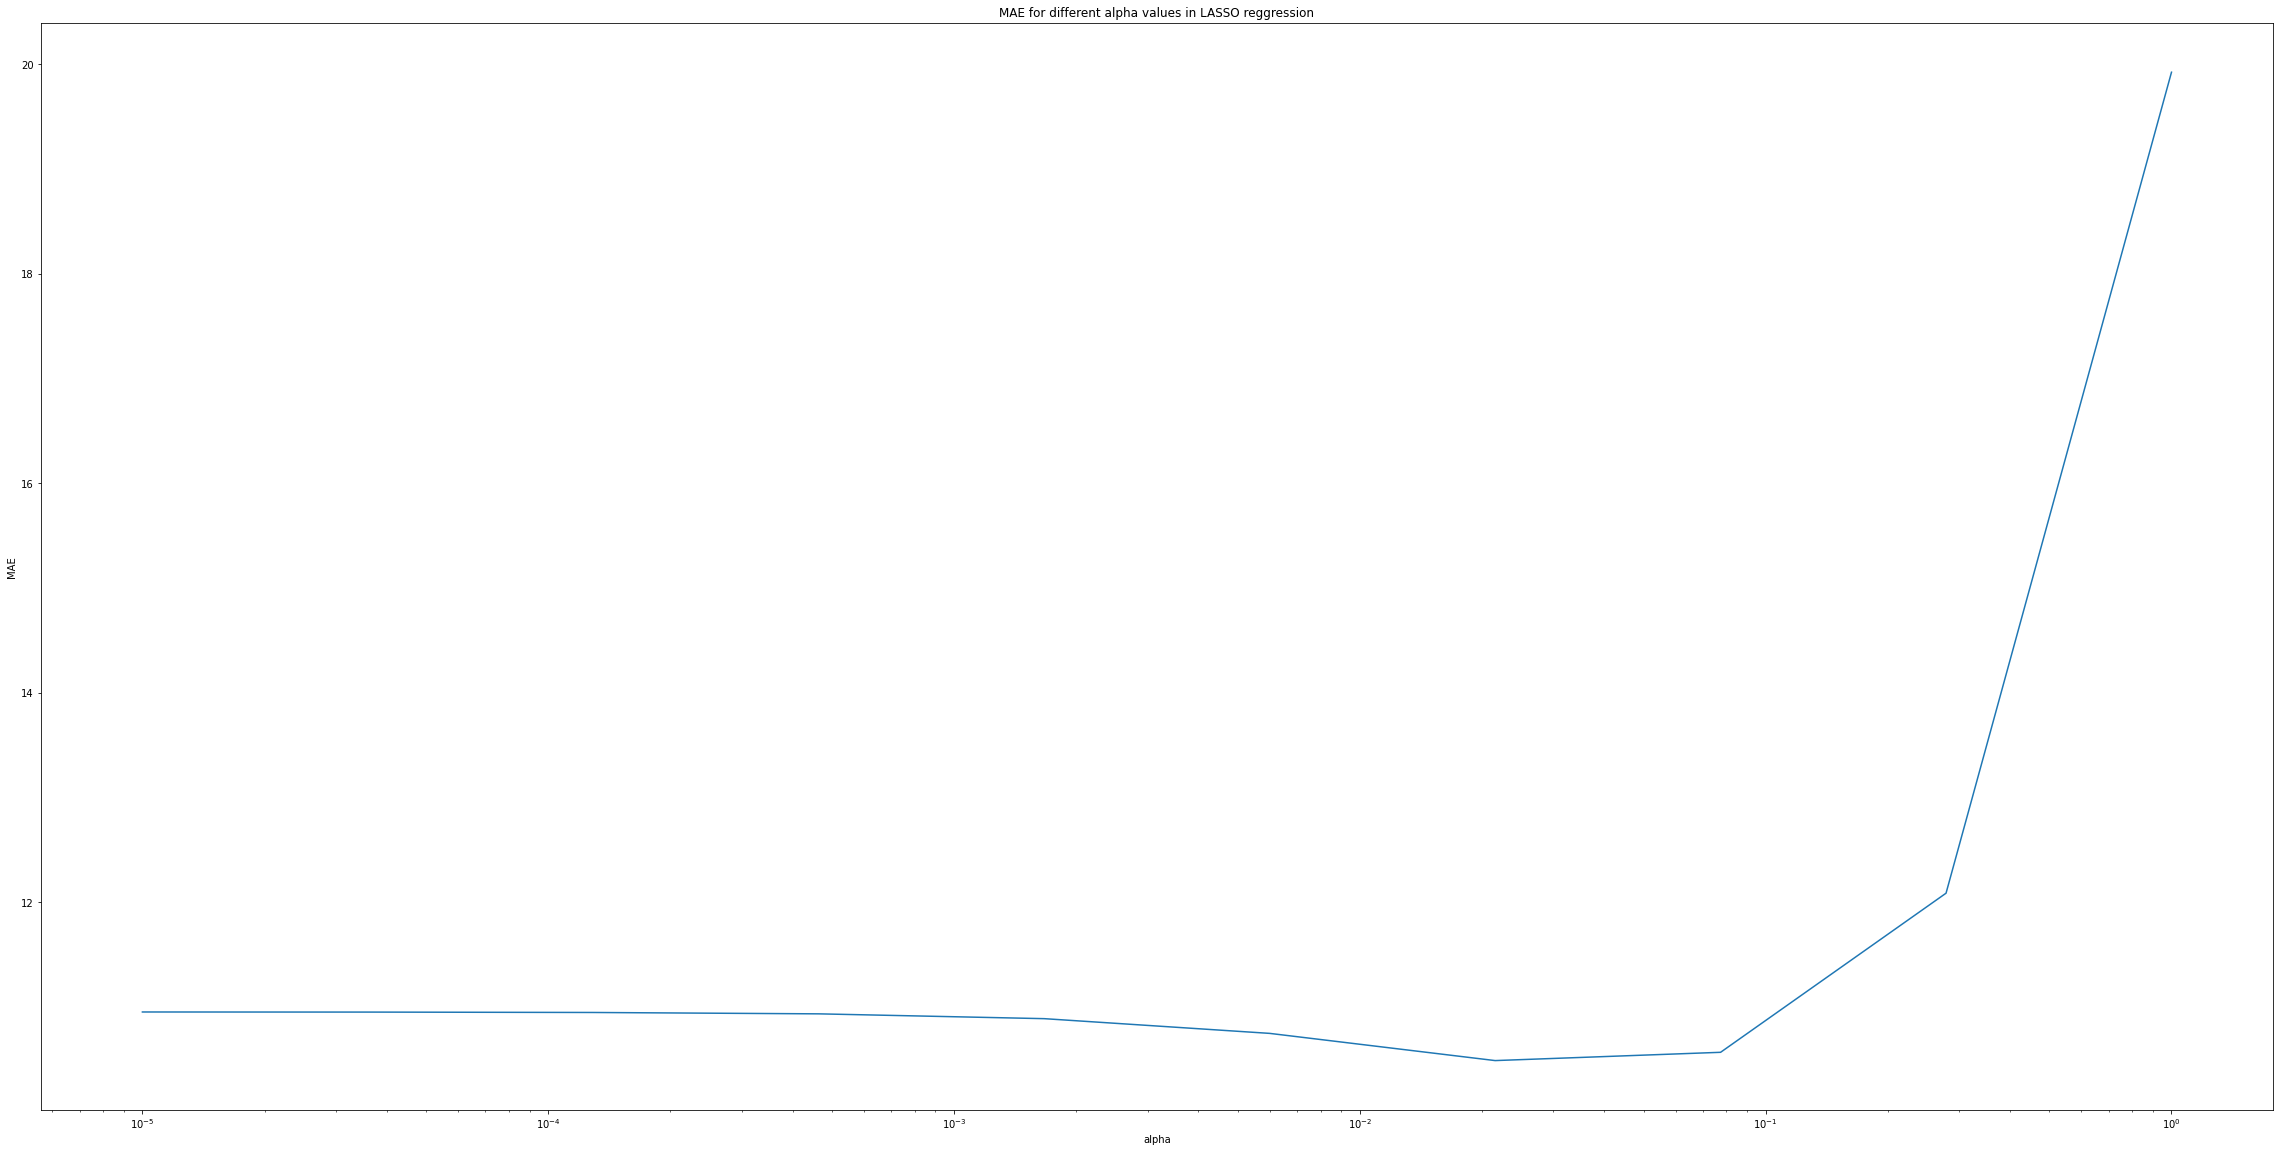

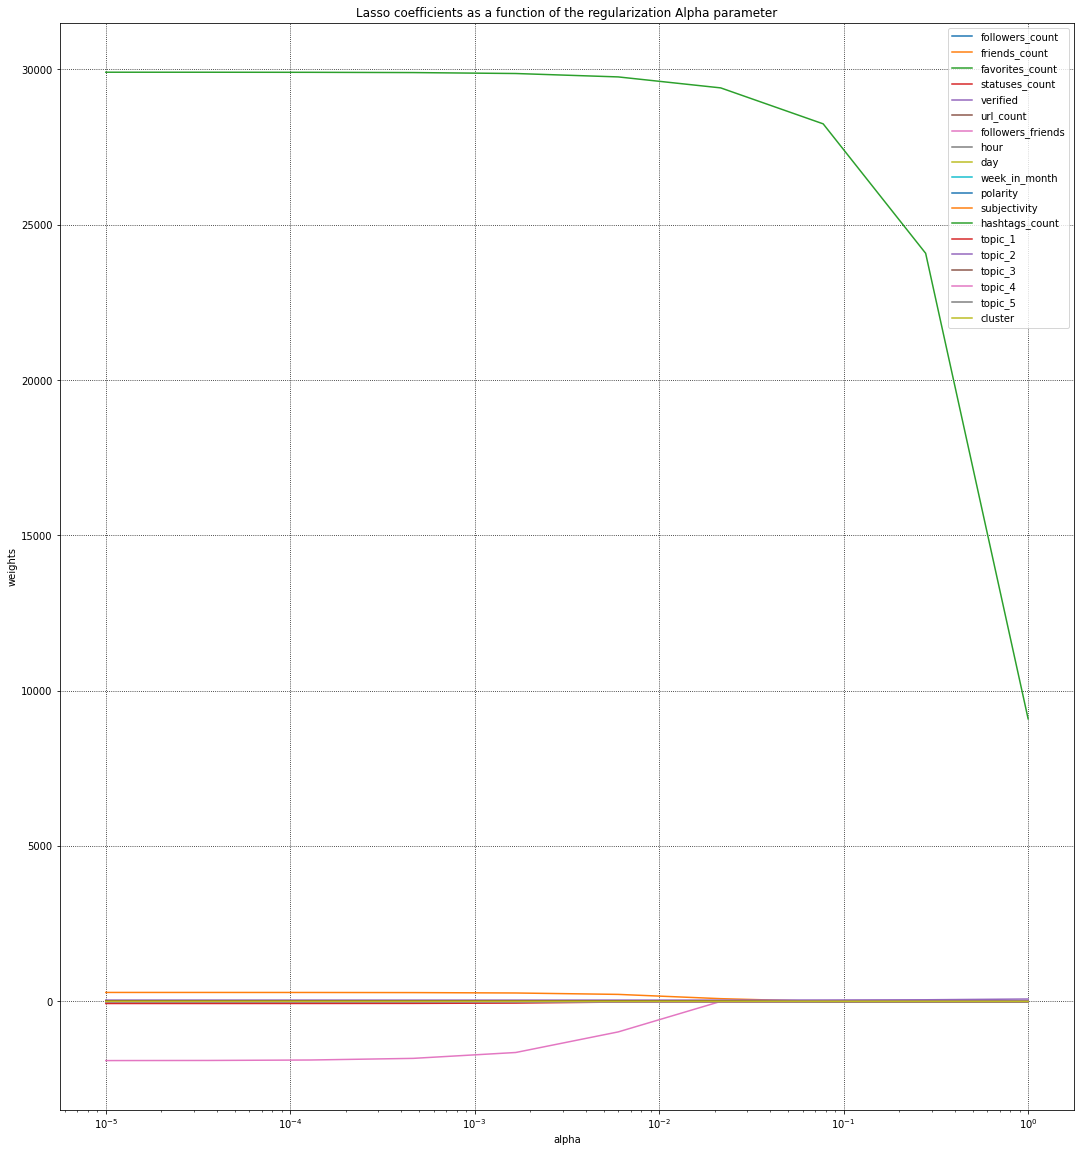

In [ ]:
# Now we can train our model.  we set our loss function 
from sklearn.linear_model import Lasso

#plot linear regression result with LASSO regularization with alpha between 0 and 1
alpha = np.logspace(-5, 0, 10)
mae = []
coefs = []
train_lasso=scaled_train_data###To change with the new train data identified for LR
test_lasso=scaled_test_data###To change with the new test data identified for LR
for a in alpha:
    reg = Lasso(alpha=a)
    reg.fit(train_lasso,y_train )
    pred = reg.predict(test_lasso)
    mae.append(mean_absolute_error(pred, y_test))
    coefs.append(reg.coef_)

#size of the plot
plt.figure(figsize=(40, 20))
ax = plt.gca()
ax.plot(alpha, mae)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title("MAE for different alpha values in LASSO reggression")

plt.show()

#plot lasso coefficients for different alpha values
plt.figure(figsize=(40, 20))
plt.subplot(121)
ax = plt.gca()
ax.plot(alpha, coefs)
ax.legend(new_train_data.columns)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization Alpha parameter')
plt.axis('tight')
plt.grid(color='black', linestyle='dotted')
plt.show()

## KNN

In [ ]:
#test different knn
from sklearn.neighbors import KNeighborsRegressor
train_knn=  scaled_train_data###To change with the new train data identified for KNN. Same for test_knn
test_knn= scaled_test_data
mae = []
for i in range(1, 10):
    knn = KNeighborsRegressor(i)
    knn.fit(train_knn, y_train)
    pred = knn.predict(test_knn)
    mae.append(mean_absolute_error(pred, y_test))

plt.figure(figsize=(40, 20))
plt.plot(range(1, 10), mae)
plt.xlabel('K')
plt.ylabel('MAE')
plt.title("MAE for different K values in KNN regression")



## Random Forest

In [ ]:
#grid search random forest on nb estimators and max leaf nodes
from sklearn.model_selection import GridSearchCV
train_rf=new_train_data###To change with the new train data identified for RF. Same for test_rf
param_grid = {
    'n_estimators': [10, 30, 50, 70, 90],
    'max_leaf_nodes': [1000,1400,1800,2200]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)   
grid_search.fit(train_knn, y_train)
grid_search.best_params_


### Optimising hyperparameters with automl

Using the flaml library to optimise hyperparameters

In [ ]:
from flaml import AutoML
automl = AutoML()

settings = {
    "time_budget": 300,
    "metric": 'mae',
    "task": 'regression',
    'estimator_list': ['rf'],
    "seed": 7654321,
}

automl.fit(new_train_data, y_train, **settings)
# Print the best model
print(automl.model.estimator)

[flaml.automl: 12-02 16:24:56] {2599} INFO - task = regression
[flaml.automl: 12-02 16:24:56] {2601} INFO - Data split method: uniform
[flaml.automl: 12-02 16:24:56] {2604} INFO - Evaluation method: holdout
[flaml.automl: 12-02 16:24:56] {2726} INFO - Minimizing error metric: mae
[flaml.automl: 12-02 16:24:56] {2870} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 12-02 16:24:56] {3166} INFO - iteration 0, current learner rf
[flaml.automl: 12-02 16:24:57] {3296} INFO - Estimated sufficient time budget=138641s. Estimated necessary time budget=139s.
[flaml.automl: 12-02 16:24:57] {3343} INFO -  at 1.2s,	estimator rf's best error=10.9039,	best estimator rf's best error=10.9039
[flaml.automl: 12-02 16:24:57] {3166} INFO - iteration 1, current learner rf
[flaml.automl: 12-02 16:24:57] {3343} INFO -  at 1.2s,	estimator rf's best error=10.7765,	best estimator rf's best error=10.7765
[flaml.automl: 12-02 16:24:57] {3166} INFO - iteration 2, current learner rf
[flaml.automl: 12-

RandomForestRegressor(max_features=0.9485155714139415, max_leaf_nodes=107,
                      n_estimators=9, n_jobs=-1)


## Part 4 : Visualising importance of model features

In [ ]:
# select the best models and choose best features for each

models = [
    GradientBoostingRegressor(),
    RandomForestRegressor(n_estimators=10),
    RandomForestRegressor(max_features=0.93, max_leaf_nodes=2310, n_estimators=90, n_jobs=-1),
    XGBRegressor(base_score=0.5, booster='gbtree')
]

model = models[2]
model.fit(new_train_data, y_train)

RandomForestRegressor(max_features=0.93, max_leaf_nodes=2310, n_estimators=90,
                      n_jobs=-1)

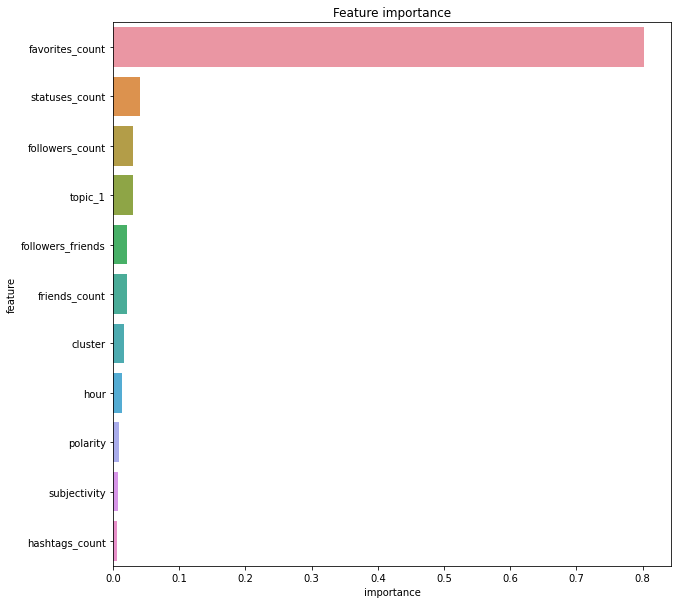

<AxesSubplot:>

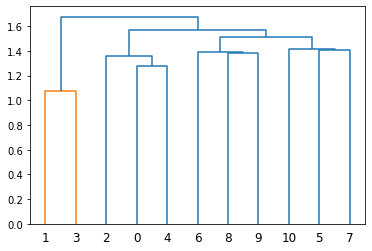

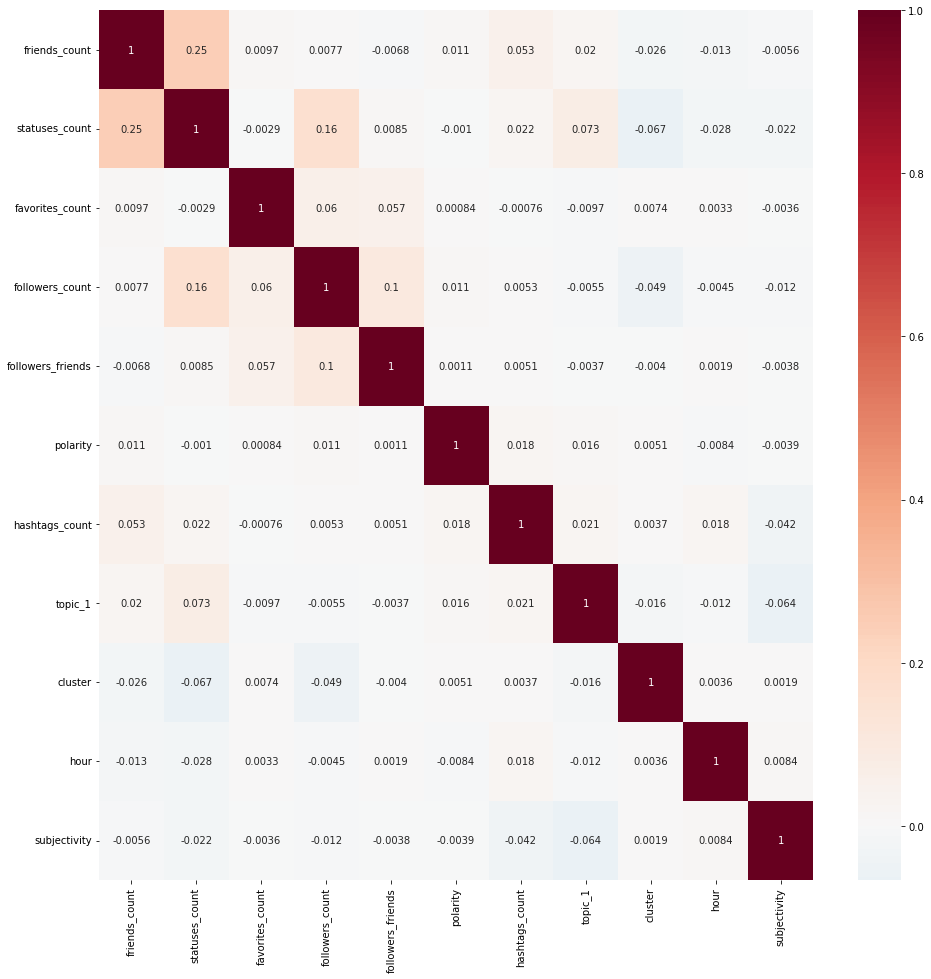

In [ ]:
from scipy.cluster import hierarchy

%matplotlib inline

# Plot feature importance
feature_importance = pd.DataFrame({'feature': new_train_data.columns, 'importance': model.feature_importances_})
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature importance')
plt.show()


# plot correlation of features
order = np.array(hierarchy.dendrogram(hierarchy.ward(new_train_data.corr()), no_plot=False)['ivl'], dtype="int")
rearranged_cov = new_train_data.corr().iloc[order, order]
plt.figure(figsize=(16, 16))
sns.heatmap(rearranged_cov, annot=True, cmap="RdBu_r", center=0)

In [ ]:
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
2,favorites_count,0.802754
3,statuses_count,0.040662
0,followers_count,0.030948
9,topic_1,0.030689
4,followers_friends,0.021550
1,friends_count,0.021267
10,cluster,0.016540
5,hour,0.013547
6,polarity,0.008952
7,subjectivity,0.007275


In [ ]:
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_regression

In [ ]:
# Get accuracy of the model for different number of features

acc = []

for i in range(1, len(columns) - len(useless_cols) - len(unimportant_cols)):
    # apply SelectKBest class to extract top i best features
    k_best_fit = SelectKBest(score_func=f_regression, k=i).fit(new_train_data, y_train)
    # transform both train and test
    X_train_new = k_best_fit.transform(new_train_data)
    X_test_new = k_best_fit.transform(new_test_data)
    # fit the model and predict
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    y_pred = [round(value) if value >= 0 else 0 for value in y_pred]
    acc.append(mean_absolute_error(y_test, y_pred))

print(f"Best accuracy with that model : {min(acc)}")

Best accuracy with that model : 6.665776760742435


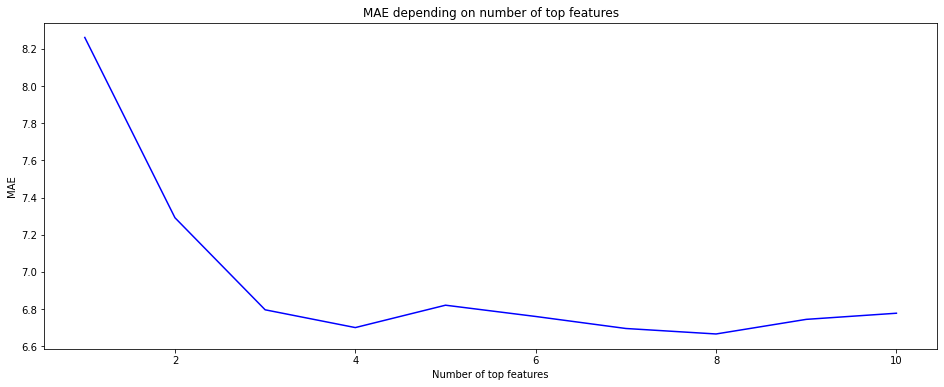

In [ ]:
# Plot the accuracy
plt.figure(figsize=(16, 6))
plt.plot(range(1, len(columns) - len(useless_cols) - len(unimportant_cols)), acc, c='b')
plt.title("MAE depending on number of top features")
plt.xlabel("Number of top features")
plt.ylabel("MAE")
plt.show()

In [ ]:
# Print best features
k_best_fit = SelectKBest(score_func=f_regression, k=np.argmin(np.array(acc))).fit(new_train_data, y_train)
n_best = 1 + np.argmin(np.array(acc))
best_features_names = [x for _, x in sorted(zip(k_best_fit.scores_, k_best_fit.feature_names_in_), reverse=True)][:n_best]
print(best_features_names)

['favorites_count', 'followers_count', 'followers_friends', 'friends_count', 'cluster', 'topic_1', 'hashtags_count', 'subjectivity']
